In [14]:
import os
import sys
import mne
from facet.facet import facet
from loguru import logger
from mne.annotations import Annotations
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../src")
from facet.Epilepsy.template_utils import build_template, find_best_ica, pearson_r, compute_spike_regressors
from facet.Epilepsy.template_utils import scale_eeg_to, quick_spike_overview, list_top_spike_channels, basic_clean, compute_adaptive_threshold, plot_ica_with_annotations
import scipy.stats as st
from scipy.signal import find_peaks
from scipy.io import loadmat
import mne
import numpy as np

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

f = facet()

Exists: True
▶ Before filtering: max ≈ 6716.4 µV, min ≈ -4444.0 µV
▶ After filtering:  max ≈ 2406.3 µV, min ≈ -2696.6 µV


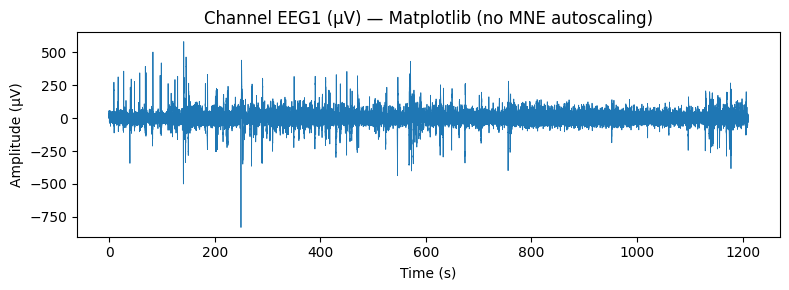

Now launching the MNE browser; pink bar = ±200 µV


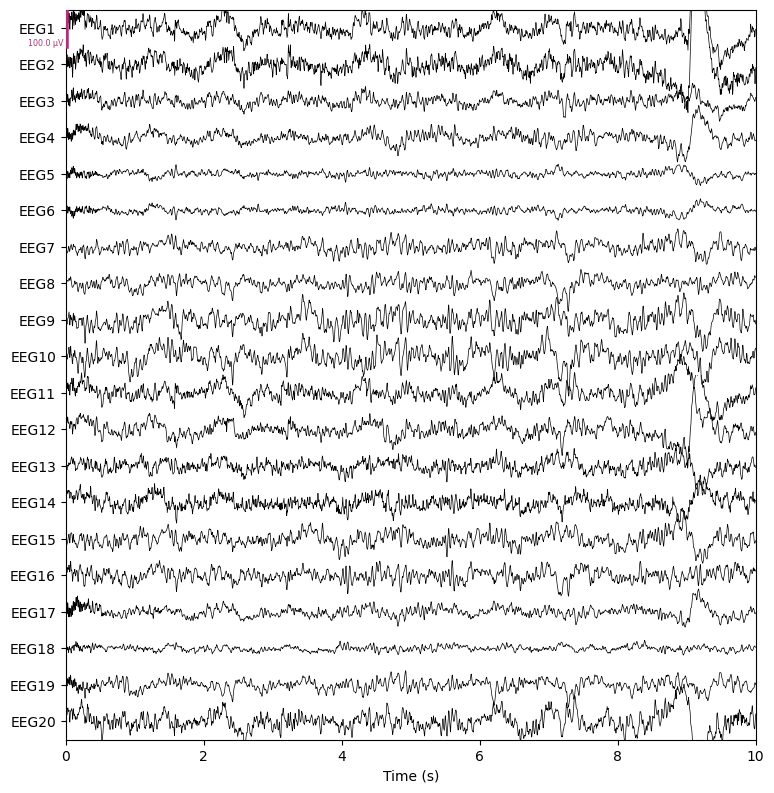

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.io import loadmat

# 1) Load the .mat file
path = r"G:\Medical Engineering and Analytics\Project\FACETpy\examples\datasets\MAT_Files\DA00100S.mat"
print("Exists:", os.path.exists(path))  # Should be True
mat = loadmat(path)
eeg = mat['eeg_data']  # shape (n_ch, n_samples), raw numbers
eeg_uV = mat["eeg_data"]       
# 2) Build an MNE RawArray in volts
sfreq   = 500.0  # Hz
ch_names = [f"EEG{i+1}" for i in range(eeg.shape[0])]
info     = mne.create_info(ch_names, sfreq, ch_types="eeg")
raw      = mne.io.RawArray(eeg, info)

# 3) Print basic stats in µV
before_max_uv = raw.get_data().max() * 1e6
before_min_uv = raw.get_data().min() * 1e6
print(f"▶ Before filtering: max ≈ {before_max_uv:.1f} µV, min ≈ {before_min_uv:.1f} µV")

# 4) Notch + band-pass (all in volts!)
raw.notch_filter([50, 100], picks="eeg", verbose=False)
raw.filter(1.0, 70.0, picks="eeg", verbose=False)

# 5) Print stats *after* filtering (still in volts internally)
after_max_uv = raw.get_data().max() * 1e6
after_min_uv = raw.get_data().min() * 1e6
print(f"▶ After filtering:  max ≈ {after_max_uv:.1f} µV, min ≈ {after_min_uv:.1f} µV")

# 6) Plain-Jane Matplotlib plot of channel 1 in µV
data_uv = raw.get_data(picks=[0])[0] * 1e6
times   = np.arange(data_uv.size) / sfreq
plt.figure(figsize=(8,3))
plt.plot(times, data_uv, lw=0.6)
plt.title("Channel EEG1 (µV) — Matplotlib (no MNE autoscaling)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.tight_layout()
plt.show()

# 7) MNE browser with a fixed ±200 µV scale
#    (i.e. 200e-6 V in MNE’s world)
scalings = {"eeg": 50e-6}
print("Now launching the MNE browser; pink bar = ±200 µV")
raw.plot(duration=10, scalings=scalings, show_scrollbars=False)
plt.close("all")


### PRINT annotation times

In [17]:

events = mat['events']
for row in events:
    time_str, _, label = row
    print("Label:", label, "at time (s):", float(time_str))


Label: Waking                           at time (s): 1.034
Label: !                                at time (s): 367.24
Label: !                                at time (s): 495.364
Label: !                                at time (s): 663.518
Label: !                                at time (s): 666.01
Label: !                                at time (s): 675.398
Label: !                                at time (s): 680.818
Label: !                                at time (s): 687.682
Label: !                                at time (s): 703.688
Label: !                                at time (s): 778.554
Label: !                                at time (s): 790.966
Label: !                                at time (s): 830.794
Label: !                                at time (s): 845.936
Label: !                                at time (s): 854.316
Label: !                                at time (s): 862.404
Label: !                                at time (s): 883.516
Label: !                    

### MANUALLY DETECT SPIKE

found 29 spikes
segments.shape = (29, 150)


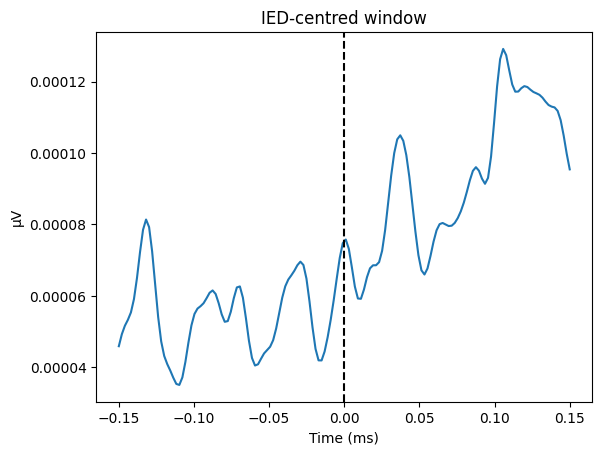

In [18]:

chan_idx   = 0      # channel you want
half_win_s = 0.15   # 100 ms before & after the spike

# 1) grab the spike times (seconds) 
events = mat["events"]
spike_sec = [float(r[0]) for r in events if r[2].strip() == "!"]
print(f"found {len(spike_sec)} spikes")

# 2) convert to samples and slice out windows 
half_samp = int(round(half_win_s * sfreq))
data      = raw.get_data(picks=[chan_idx])[0]   # 1-D array
segments  = []

for t in spike_sec:
    idx   = int(round(t * sfreq))
    start = idx - half_samp
    stop  = idx + half_samp
    if 0 <= start and stop <= data.size:
        segments.append(data[start:stop])

segments = np.stack(segments)        # (n_spikes, 2*half_samp)
print("segments.shape =", segments.shape)

# 3) quick check: plot first segment 
t_axis = np.linspace(-half_win_s, half_win_s, segments.shape[1])  # ms
plt.plot(t_axis, segments[0])
plt.axvline(0, ls="--", color="k")
plt.xlabel("Time (ms)")
plt.ylabel("µV")
plt.title("IED-centred window")
plt.show()


### TOP SPIKE CHANNEL BY AMPLITUDE

In [19]:
import numpy as np
raw = scale_eeg_to(raw, "uV")  

# List the 5 best channels (index, name, mean P–P in µV)
top5 = list_top_spike_channels(raw, spike_sec, half_win_s=0.15, top_n=5)

print("Top channels by spike amplitude:")
for idx, name, pp in top5:
    print(f"  {idx:2d} : {name:<10s} : {pp:.1f} µV")


Scaling EEG from volts → microvolts.
Top channels by spike amplitude:
  23 : EEG24      : 1306.3 µV
  25 : EEG26      : 496.5 µV
  26 : EEG27      : 465.5 µV
  24 : EEG25      : 395.4 µV
  22 : EEG23      : 279.7 µV


### SPIKE OVERVIEW SELECTED CHANNELS

In [ ]:
quick_spike_overview(raw, spike_sec, highlight_ch=23,
                     window_s=0.4, n_spikes=3)

### SPIKE OVERVIEW BAD CHANNELS?

In [ ]:
for ch in [25,26,27,28]:      # zero-based indices for EEG 26–29
    print(f"\n===== CHANNEL {ch} : {raw.ch_names[ch]} =====")
    quick_spike_overview(raw, spike_sec, 
                         highlight_ch=ch, 
                         window_s=0.4, 
                         n_spikes=3)

### BUILD TEMPLATE

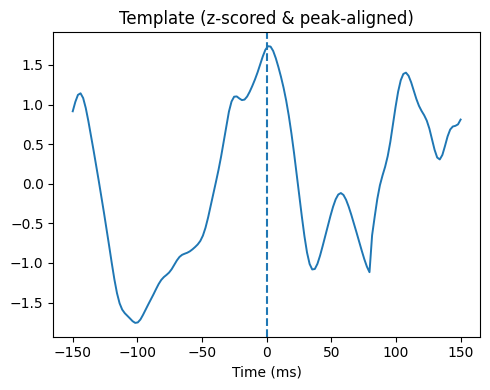

In [20]:
best_ch, template_z, half_shift = build_template(raw, spike_sec, half_win_s=0.15)

### CORRELATION ICA

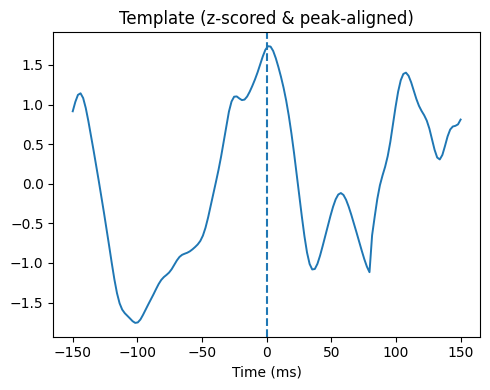

Caught  3/29 spikes within ±0.1s:
  → caught: [680.818, 830.794, 951.762]
  → missed: [367.24, 495.364, 663.518, 666.01, 675.398, 687.682, 703.688, 778.554, 790.966, 845.936, 854.316, 862.404, 883.516, 887.618, 908.202, 936.894, 1002.86, 1017.092, 1020.844, 1053.176, 1057.286, 1063.29, 1083.55, 1098.494, 1134.108, 1169.154]


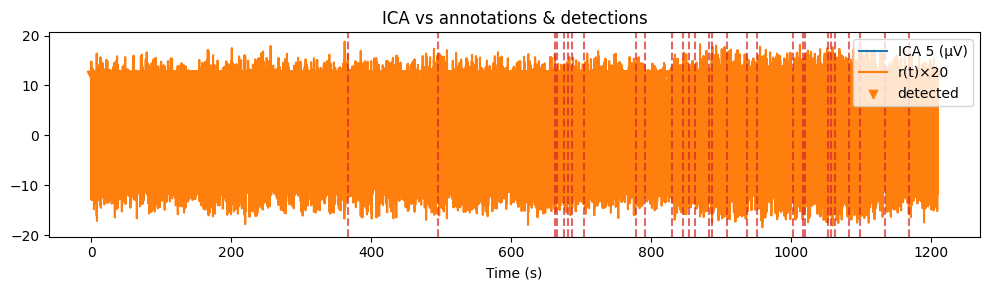

True positives  : 3 detections at [680.792, 830.796, 951.702]
False positives : 1108 detections at [0.084, 2.04, 7.242, 7.726, 8.324, 9.568, 10.514, 11.638, 12.722, 13.21]…


In [21]:

# 3) Now run your existing pipeline *unchanged*, with th_ica=0.85:
template_z, r_raw, r_ica, peaks_raw, peaks_ica, best_ch, best_ica_idx, caught, missed = \
    compute_spike_regressors(raw, spike_sec,
                             half_win_s=0.15,
                             th_raw=0.40, th_ica=0.60,
                             min_dist_s=0.3,
                             match_tol_s=0.1)

det_times = peaks_ica / sfreq

# true positives: any det_time within ±tol of any manual time
tol = 0.1
true_pos = [t for t in det_times
            if any(abs(t - s) <= tol for s in spike_sec)]
false_pos = [t for t in det_times
             if all(abs(t - s) > tol for s in spike_sec)]

print(f"True positives  : {len(true_pos)} detections at {true_pos}")
print(f"False positives : {len(false_pos)} detections at {false_pos[:10]}…")


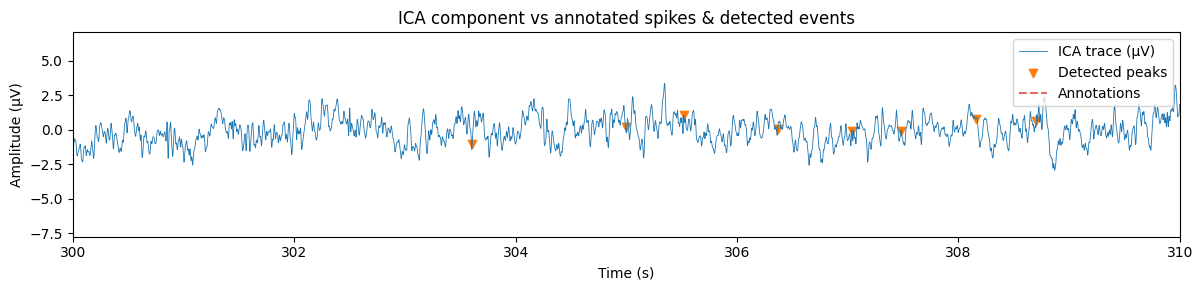

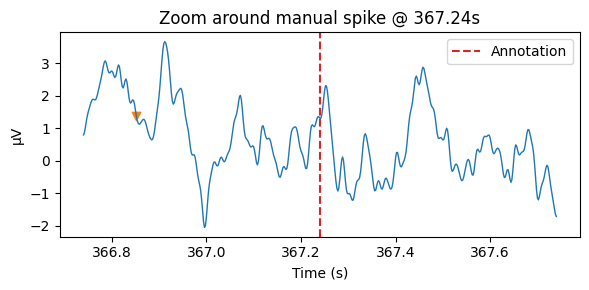

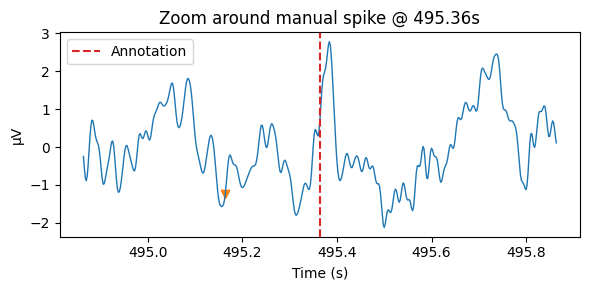

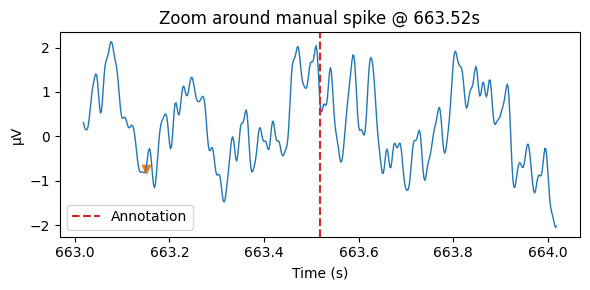

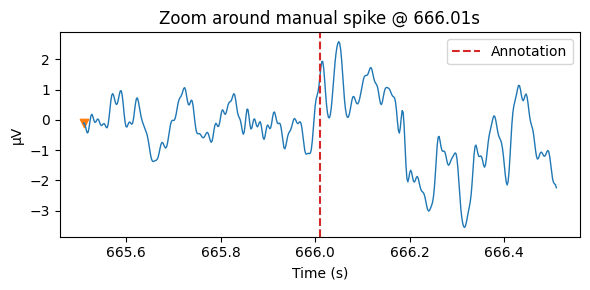

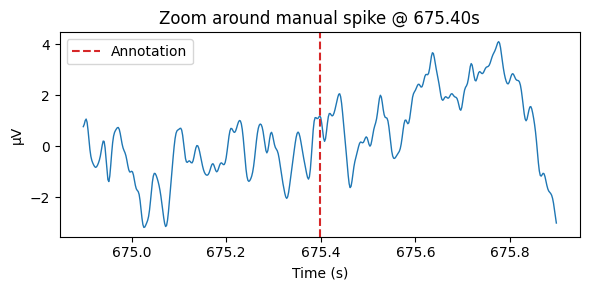

In [22]:
# get the ICA time series in µV
_, ica_trace, _ = find_best_ica(raw, template_z, half_shift)

# now plot
plot_ica_with_annotations(raw, ica_trace, peaks_ica, spike_sec,
                          match_tol_s=0.1, tmin=300, tmax=310)

### MANUAL INSPECTION

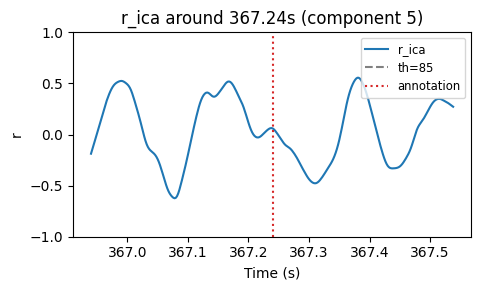

r_ica at 367.24s = 0.060  (threshold is 85)


In [23]:
sfreq = raw.info['sfreq']
times = np.arange(len(r_ica)) / sfreq

# 2) find the index of your manual spike
t_man   = 367.24
idx_man = int(round(t_man * sfreq))

# 3) extract a ±0.3 s window around that index
win_s    = 0.3
half_samp= int(win_s * sfreq)
sel      = slice(idx_man - half_samp, idx_man + half_samp)

# 4) plot r_ica there
plt.figure(figsize=(5,3))
plt.plot(times[sel], r_ica[sel], label='r_ica')
plt.axhline(85, color='gray', ls='--', label=f'th={85}')
plt.axvline(t_man, color='C3', ls=':', label='annotation')
plt.ylim(-1,1)
plt.xlabel('Time (s)')
plt.ylabel('r')
plt.legend(loc='upper right', fontsize='small')
plt.title(f"r_ica around {t_man}s (component {best_ica_idx})")
plt.tight_layout()
plt.show()

# 5) print the exact correlation at the annotated time
print(f"r_ica at {t_man}s = {r_ica[idx_man]:.3f}  (threshold is {85})")